# Football_analysis

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
con = sqlite3.Connection('database.sqlite')
cur = con.cursor()

- The name of the team
- The total number of goals scored by the team during the 2011 season
- The total number of wins the team earned during the 2011 season
- A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
- The team's win percentage on days where it was raining during games in the 2011 season.

## Loading matches table

In [2]:
cur.execute("""Select name
               From sqlite_master 
               Where type="table";""")
print(cur.fetchall())

[('sqlite_sequence',), ('Matches',), ('Teams_in_Matches',), ('Teams',), ('Unique_Teams',)]


In [3]:
cur.execute("""Select * 
               From Matches
;""")
matches_df = pd.DataFrame(cur.fetchall())
matches_df.columns = [x[0] for x in cur.description]

In [4]:
cur.execute("""Select *
               From Matches
               Where Season == '2011'
               Group By 1
;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [5]:
cur.execute("""Select HomeTeam, sum(FTHG)
               From Matches
               Where Season == '2011'
               Group By 1
;""")
hometeam_df = pd.DataFrame(cur.fetchall())
hometeam_df.columns = [x[0] for x in cur.description]
hometeam_df.head()

,HomeTeam,sum(FTHG)
0,Aachen,15
1,Arsenal,39
2,Aston Villa,20
3,Augsburg,20
4,Bayern Munich,49


In [6]:
cur.execute("""Select AwayTeam, sum(FTAG)
               From Matches
               Where Season == '2011'
               Group By 1
;""")
awayteam_df = pd.DataFrame(cur.fetchall())
awayteam_df.columns = [x[0] for x in cur.description]
awayteam_df.head()

,AwayTeam,sum(FTAG)
0,Aachen,15
1,Arsenal,35
2,Aston Villa,17
3,Augsburg,16
4,Bayern Munich,28


In [7]:
total_score_df = pd.concat([hometeam_df.set_index('HomeTeam'), awayteam_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()

total_score_df['total_score'] = total_score_df['sum(FTHG)']+total_score_df['sum(FTAG)']
del total_score_df['sum(FTHG)']
del total_score_df['sum(FTAG)']
total_score_df.rename(columns={'index':'Team'
                          }, 
                 inplace=True)
total_score_df.head()

,Team,total_score
0,Aachen,30
1,Arsenal,74
2,Aston Villa,37
3,Augsburg,36
4,Bayern Munich,77


In [8]:
cur.execute("""Select HomeTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='H')
               Group By 1
;""")
homewin_df = pd.DataFrame(cur.fetchall())
homewin_df.columns = [x[0] for x in cur.description]
homewin_df.head()

,HomeTeam,Count(FTR)
0,Aachen,4
1,Arsenal,12
2,Aston Villa,4
3,Augsburg,6
4,Bayern Munich,14


In [9]:
cur.execute("""Select AwayTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='A')
               Group By 1
;""")
awaywin_df = pd.DataFrame(cur.fetchall())
awaywin_df.columns = [x[0] for x in cur.description]


awaywin_df.rename(columns={'Count(FTR)':'Count2(FTR)'
                          }, 
                 inplace=True)
awaywin_df.head()

,AwayTeam,Count2(FTR)
0,Aachen,2
1,Arsenal,9
2,Aston Villa,3
3,Augsburg,2
4,Bayern Munich,9


In [18]:
total_win_df = pd.concat([homewin_df.set_index('HomeTeam'), awaywin_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()

total_win_df['total_win'] = total_win_df['Count(FTR)']+total_win_df['Count2(FTR)']
del total_win_df['Count(FTR)']
del total_win_df['Count2(FTR)']
total_win_df.rename(columns={'index':'Team'
                          }, 
                 inplace=True)
total_win_df.head()

# pd.concat([df1.set_index('A'),df2.set_index('A')], axis=1, join='inner').reset_index()


,Team,total_win
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23


In [19]:
cur.execute("""Select HomeTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='A')
               Group By 1
;""")
homelose_df = pd.DataFrame(cur.fetchall())
homelose_df.columns = [x[0] for x in cur.description]
homelose_df.head()

,HomeTeam,Count(FTR)
0,Aachen,7
1,Arsenal,3
2,Aston Villa,8
3,Augsburg,4
4,Bayern Munich,2


In [20]:
cur.execute("""Select AwayTeam, Count(FTR)
               From Matches
               Where (Season == '2011')& (FTR =='H')
               Group By 1
;""")
awaylose_df = pd.DataFrame(cur.fetchall())
awaylose_df.columns = [x[0] for x in cur.description]


awaylose_df.rename(columns={'Count(FTR)':'Count2(FTR)'
                          }, 
                 inplace=True)
awaylose_df.head()

,AwayTeam,Count2(FTR)
0,Aachen,8
1,Arsenal,7
2,Aston Villa,6
3,Augsburg,8
4,Bayern Munich,5


In [21]:
result3 = pd.concat([homelose_df.set_index('HomeTeam'), awaylose_df.set_index('AwayTeam')], axis=1, join='inner').reset_index()
result3
result3['total_lose'] = result3['Count(FTR)']+result3['Count2(FTR)']
result3.head()

,index,Count(FTR),Count2(FTR),total_lose
0,Aachen,7,8,15
1,Arsenal,3,7,10
2,Aston Villa,8,6,14
3,Augsburg,4,8,12
4,Bayern Munich,2,5,7


In [24]:
result4 = pd.concat([total_win_df.set_index('Team'), result3.set_index('index')], axis=1, join='inner').reset_index()
result4.head()

,index,total_win,Count(FTR),Count2(FTR),total_lose
0,Aachen,6,7,8,15
1,Arsenal,21,3,7,10
2,Aston Villa,7,8,6,14
3,Augsburg,8,4,8,12
4,Bayern Munich,23,2,5,7


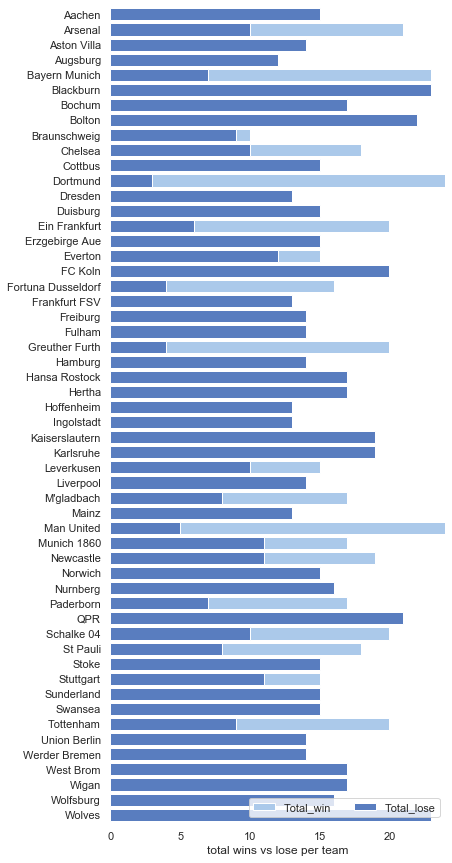

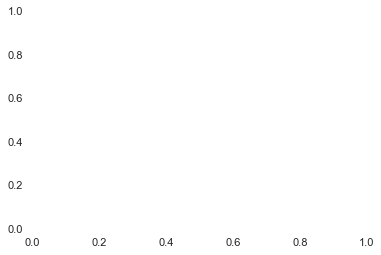

In [155]:
f, ax = plt.subplots(figsize=(6, 15))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_color_codes("pastel")
sns.barplot(x="total_win", y="index", data=result4,
            label="Total_win", color="b")
sns.set_color_codes("muted")
sns.barplot(x="total_lose", y="index", data=result4,
            label="Total_lose", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="total wins vs lose per team")
sns.despine(left=True, bottom=True)
fig, ax = plt.subplots()

In [110]:
df['Date']

0      2012-03-31
1      2011-12-11
2      2011-08-13
3      2011-11-27
4      2012-02-18
          ...    
987    2012-05-13
988    2012-05-13
989    2012-05-13
990    2012-05-13
991    2012-05-13
Name: Date, Length: 992, dtype: object

In [174]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)
keys = get_keys("/Users/shuyuwu/mod_2_project/student_repo/mod_2/project/key.json")
api_key = keys['api_key']

In [174]:
dfs=[]
for date in df['Date']:
#     date = df['Date'][0]
    latitude = 52.5200
    longitude = 13.4050

        # Create ISO date-time string
    iso_date_time = date + "T00:00:00Z"

        # Create URL template
    url_template = "https://api.darksky.net/forecast/{}/{},{},{}?exclude=currently,hourly"

        # Create request URL
    request_url = url_template.format(
            api_key,
            latitude,
            longitude,
            iso_date_time)

        # Get historical weather data as JSON 
    response = requests.get(request_url)

    df = pd.DataFrame(response.json()['daily']['data'])
    dfs.append(df)
    
daily_df=pd.concat(dfs, ignore_index=True)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [28]:
daily_df.head()

,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,dewPoint,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
0,36.34,1333188780,23.96,1333256040,40.06,1333144800,31.84,1333223760,0.71,33.58,...,38.59,1333218000,1333144800,3.0,1.333192e+09,6.174,302,40.29,1.333163e+09,17.31
1,34.94,1323605040,23.68,1323659100,34.94,1323605040,25.47,1323586860,0.56,29.15,...,32.70,1323588960,1323558000,0.0,1.323601e+09,6.212,220,15.03,1.323561e+09,9.66
2,73.67,1313241960,59.00,1313276400,73.67,1313241960,60.54,1313194740,0.56,55.77,...,59.87,1313195400,1313186400,5.0,1.313234e+09,5.803,262,10.02,1.313240e+09,5.37
3,50.77,1322408400,33.91,1322463600,50.77,1322408400,39.79,1322348400,0.73,40.02,...,45.92,1322348400,1322348400,1.0,1.322391e+09,6.216,243,41.17,1.322412e+09,19.56
4,42.45,1329573780,28.71,1329634800,42.45,1329573780,30.32,1329527400,0.79,36.41,...,34.83,1329526920,1329519600,1.0,1.329564e+09,5.508,213,14.99,1.329588e+09,8.17


In [108]:
daily_df[daily_df['time'] == 1310688000]

,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,dewPoint,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed


In [30]:
daily_df['summary']

0      Drizzle in the morning and afternoon.
1          Mostly cloudy throughout the day.
2          Partly cloudy throughout the day.
3                      Windy in the evening.
4                         Drizzle overnight.
                       ...                  
987        Mostly cloudy throughout the day.
988        Mostly cloudy throughout the day.
989        Mostly cloudy throughout the day.
990        Mostly cloudy throughout the day.
991        Mostly cloudy throughout the day.
Name: summary, Length: 992, dtype: object

In [31]:
df['weather'] = daily_df['icon']

In [32]:
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,rain
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,partly-cloudy-day
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,partly-cloudy-day
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,wind
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,partly-cloudy-day


In [33]:
daily_df.to_csv('daily_weather.csv', index=False)

In [34]:
def rainy_day(df):
    for i in list(range(0,len(df))):
        if (df['weather'][i] == 'rain'):
            df['weather'][i] = 1
        else:
            df['weather'][i] = 0

rainy_day(df)
df.rename(columns={'weather': 'rainy'}, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,rainy
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,1
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,0
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0


In [36]:
from pandasql import sqldf

In [37]:
pysqldf = lambda q: sqldf(q, globals())
q1 = "Select HomeTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='H')&(rainy==1) Group By 1;"
q2 = "Select HomeTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='H') Group By 1;"

homewin_rainy_df = pysqldf(q1)
total_homewin_df = pysqldf(q2)

homewin_rainy_df.rename(columns={'Count(FTR)':'Total_win_on_rainy'
                          }, 
                 inplace=True)
homewin_rainy_df.head()

,HomeTeam,Total_win_on_rainy
0,Arsenal,1
1,Augsburg,3
2,Bayern Munich,2
3,Blackburn,1
4,Bochum,1


In [38]:
total_homewin_df

total_homewin_df.rename(columns={'Count(FTR)':'Total_win'
                          }, 
                 inplace=True)
total_homewin_df.head()

,HomeTeam,Total_win
0,Aachen,4
1,Arsenal,12
2,Aston Villa,4
3,Augsburg,6
4,Bayern Munich,14


In [39]:
Hometeam_win = pd.merge(total_homewin_df, homewin_rainy_df, on ='HomeTeam', how='outer')
Hometeam_win.rename(columns={'HomeTeam':'Team'
                          }, 
                 inplace=True)
Hometeam_win

,Team,Total_win,Total_win_on_rainy
0,Aachen,4,NaN
1,Arsenal,12,1.0
2,Aston Villa,4,NaN
3,Augsburg,6,3.0
4,Bayern Munich,14,2.0
5,Blackburn,6,1.0
6,Bochum,7,1.0
7,Bolton,4,NaN
8,Braunschweig,6,2.0
9,Chelsea,12,2.0


In [40]:
Hometeam_win.head()

,Team,Total_win,Total_win_on_rainy
0,Aachen,4,NaN
1,Arsenal,12,1.0
2,Aston Villa,4,NaN
3,Augsburg,6,3.0
4,Bayern Munich,14,2.0


In [41]:
pysqldf = lambda q: sqldf(q, globals())
q_away_1 = "Select AwayTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='A')&(rainy==1) Group By 1;"
q_away_2 = "Select AwayTeam, Count(FTR)From df Where (Season == '2011')& (FTR =='A') Group By 1;"

awaywin_rainy_df = pysqldf(q_away_1)
total_awaywin_df = pysqldf(q_away_2)

awaywin_rainy_df.rename(columns={'Count(FTR)':'Total_win_on_rainy_away'
                          }, 
                 inplace=True)
awaywin_rainy_df.head()

,AwayTeam,Total_win_on_rainy_away
0,Aachen,2
1,Arsenal,2
2,Bayern Munich,3
3,Bochum,1
4,Bolton,3


In [42]:
total_awaywin_df.rename(columns={'Count(FTR)':'Total_win_away'
                          }, 
                 inplace=True)
total_awaywin_df.head()

,AwayTeam,Total_win_away
0,Aachen,2
1,Arsenal,9
2,Aston Villa,3
3,Augsburg,2
4,Bayern Munich,9


In [43]:
Awayteam_win = pd.merge(total_awaywin_df, awaywin_rainy_df, on ='AwayTeam', how='outer')
Awayteam_win.rename(columns={'AwayTeam':'Team'
                          }, 
                 inplace=True)
Awayteam_win.head()

,Team,Total_win_away,Total_win_on_rainy_away
0,Aachen,2,2.0
1,Arsenal,9,2.0
2,Aston Villa,3,NaN
3,Augsburg,2,NaN
4,Bayern Munich,9,3.0


In [44]:
final_rainy_df = pd.merge(Awayteam_win, Hometeam_win, on ='Team', how='outer')

In [45]:
final_rainy_df.head()

,Team,Total_win_away,Total_win_on_rainy_away,Total_win,Total_win_on_rainy
0,Aachen,2,2.0,4,NaN
1,Arsenal,9,2.0,12,1.0
2,Aston Villa,3,NaN,4,NaN
3,Augsburg,2,NaN,6,3.0
4,Bayern Munich,9,3.0,14,2.0


In [46]:
final_rainy_df.fillna(0, inplace = True) 

In [47]:
final_rainy_df.head()

,Team,Total_win_away,Total_win_on_rainy_away,Total_win,Total_win_on_rainy
0,Aachen,2,2.0,4,0.0
1,Arsenal,9,2.0,12,1.0
2,Aston Villa,3,0.0,4,0.0
3,Augsburg,2,0.0,6,3.0
4,Bayern Munich,9,3.0,14,2.0


In [48]:
q_final = "Select Team, (Total_win_on_rainy_away+Total_win_on_rainy)/(Total_win_away + Total_win) From final_rainy_df"

final_df=pysqldf(q_final)
final_df.rename(columns={'(Total_win_on_rainy_away+Total_win_on_rainy)/(Total_win_away + Total_win)':'Win chance on rainy'
                          }, 
                 inplace=True)
final_df

,Team,Win chance on rainy
0,Aachen,0.333333
1,Arsenal,0.142857
2,Aston Villa,0.000000
3,Augsburg,0.375000
4,Bayern Munich,0.217391
5,Blackburn,0.125000
6,Bochum,0.200000
7,Bolton,0.300000
8,Braunschweig,0.400000
9,Chelsea,0.277778


In [356]:
total_score_df

,Team,total_score
0,Aachen,30
1,Arsenal,74
2,Aston Villa,37
3,Augsburg,36
4,Bayern Munich,77
5,Blackburn,48
6,Bochum,41
7,Bolton,46
8,Braunschweig,37
9,Chelsea,65


In [355]:
total_win_df

,Team,total_win
0,Aachen,6
1,Arsenal,21
2,Aston Villa,7
3,Augsburg,8
4,Bayern Munich,23
5,Blackburn,8
6,Bochum,10
7,Bolton,10
8,Braunschweig,10
9,Chelsea,18


In [51]:
total_win_dict = total_win_df.to_dict(orient='records') 
total_win_dict

[{'Team': 'Aachen', 'total_win': 6},
 {'Team': 'Arsenal', 'total_win': 21},
 {'Team': 'Aston Villa', 'total_win': 7},
 {'Team': 'Augsburg', 'total_win': 8},
 {'Team': 'Bayern Munich', 'total_win': 23},
 {'Team': 'Blackburn', 'total_win': 8},
 {'Team': 'Bochum', 'total_win': 10},
 {'Team': 'Bolton', 'total_win': 10},
 {'Team': 'Braunschweig', 'total_win': 10},
 {'Team': 'Chelsea', 'total_win': 18},
 {'Team': 'Cottbus', 'total_win': 8},
 {'Team': 'Dortmund', 'total_win': 25},
 {'Team': 'Dresden', 'total_win': 12},
 {'Team': 'Duisburg', 'total_win': 10},
 {'Team': 'Ein Frankfurt', 'total_win': 20},
 {'Team': 'Erzgebirge Aue', 'total_win': 8},
 {'Team': 'Everton', 'total_win': 15},
 {'Team': 'FC Koln', 'total_win': 8},
 {'Team': 'Fortuna Dusseldorf', 'total_win': 16},
 {'Team': 'Frankfurt FSV', 'total_win': 7},
 {'Team': 'Freiburg', 'total_win': 10},
 {'Team': 'Fulham', 'total_win': 14},
 {'Team': 'Greuther Furth', 'total_win': 20},
 {'Team': 'Hamburg', 'total_win': 8},
 {'Team': 'Hannover

In [52]:
total_score_dict = total_score_df.to_dict(orient='records') 
total_score_dict

[{'Team': 'Aachen', 'total_score': 30},
 {'Team': 'Arsenal', 'total_score': 74},
 {'Team': 'Aston Villa', 'total_score': 37},
 {'Team': 'Augsburg', 'total_score': 36},
 {'Team': 'Bayern Munich', 'total_score': 77},
 {'Team': 'Blackburn', 'total_score': 48},
 {'Team': 'Bochum', 'total_score': 41},
 {'Team': 'Bolton', 'total_score': 46},
 {'Team': 'Braunschweig', 'total_score': 37},
 {'Team': 'Chelsea', 'total_score': 65},
 {'Team': 'Cottbus', 'total_score': 30},
 {'Team': 'Dortmund', 'total_score': 80},
 {'Team': 'Dresden', 'total_score': 50},
 {'Team': 'Duisburg', 'total_score': 42},
 {'Team': 'Ein Frankfurt', 'total_score': 76},
 {'Team': 'Erzgebirge Aue', 'total_score': 31},
 {'Team': 'Everton', 'total_score': 50},
 {'Team': 'FC Koln', 'total_score': 39},
 {'Team': 'Fortuna Dusseldorf', 'total_score': 64},
 {'Team': 'Frankfurt FSV', 'total_score': 43},
 {'Team': 'Freiburg', 'total_score': 45},
 {'Team': 'Fulham', 'total_score': 48},
 {'Team': 'Greuther Furth', 'total_score': 73},
 {'

In [131]:
final_dict = final_df.to_dict(orient='records') 
final_dict

[{'Team': 'Aachen', 'Win chance on rainy': 0.3333333333333333},
 {'Team': 'Arsenal', 'Win chance on rainy': 0.14285714285714285},
 {'Team': 'Aston Villa', 'Win chance on rainy': 0.0},
 {'Team': 'Augsburg', 'Win chance on rainy': 0.375},
 {'Team': 'Bayern Munich', 'Win chance on rainy': 0.21739130434782608},
 {'Team': 'Blackburn', 'Win chance on rainy': 0.125},
 {'Team': 'Bochum', 'Win chance on rainy': 0.2},
 {'Team': 'Bolton', 'Win chance on rainy': 0.3},
 {'Team': 'Braunschweig', 'Win chance on rainy': 0.4},
 {'Team': 'Chelsea', 'Win chance on rainy': 0.2777777777777778},
 {'Team': 'Cottbus', 'Win chance on rainy': 0.25},
 {'Team': 'Dortmund', 'Win chance on rainy': 0.2},
 {'Team': 'Dresden', 'Win chance on rainy': 0.25},
 {'Team': 'Duisburg', 'Win chance on rainy': 0.1},
 {'Team': 'Ein Frankfurt', 'Win chance on rainy': 0.1},
 {'Team': 'Erzgebirge Aue', 'Win chance on rainy': 0.125},
 {'Team': 'Everton', 'Win chance on rainy': 0.26666666666666666},
 {'Team': 'FC Koln', 'Win chance o

In [79]:
import pymongo
import requests

In [135]:
mydb = myclient['football_database']
mycollection = mydb['total_win_dict']
results = mycollection.insert_many(total_win_dict)
mycollection2 = mydb['total_score_dict']
results2 = mycollection2.insert_many(total_score_dict)
mycollection3 = mydb['final_dict']
results3 = mycollection3.insert_many(final_dict)

In [136]:
query_1 = mycollection3.find({})
for document in query_1:
    print(document)

{'_id': ObjectId('5df25d60a5aab5917b587598'), 'Team': 'Aachen', 'Win chance on rainy': 0.3333333333333333}
{'_id': ObjectId('5df25d60a5aab5917b587599'), 'Team': 'Arsenal', 'Win chance on rainy': 0.14285714285714285}
{'_id': ObjectId('5df25d60a5aab5917b58759a'), 'Team': 'Aston Villa', 'Win chance on rainy': 0.0}
{'_id': ObjectId('5df25d60a5aab5917b58759b'), 'Team': 'Augsburg', 'Win chance on rainy': 0.375}
{'_id': ObjectId('5df25d60a5aab5917b58759c'), 'Team': 'Bayern Munich', 'Win chance on rainy': 0.21739130434782608}
{'_id': ObjectId('5df25d60a5aab5917b58759d'), 'Team': 'Blackburn', 'Win chance on rainy': 0.125}
{'_id': ObjectId('5df25d60a5aab5917b58759e'), 'Team': 'Bochum', 'Win chance on rainy': 0.2}
{'_id': ObjectId('5df25d60a5aab5917b58759f'), 'Team': 'Bolton', 'Win chance on rainy': 0.3}
{'_id': ObjectId('5df25d60a5aab5917b5875a0'), 'Team': 'Braunschweig', 'Win chance on rainy': 0.4}
{'_id': ObjectId('5df25d60a5aab5917b5875a1'), 'Team': 'Chelsea', 'Win chance on rainy': 0.2777777

In [144]:
query_2 = mycollection2.find({})

for document in query_2:
    print(document)

{'_id': ObjectId('5df2594ea5aab5917b587560'), 'Team': 'Aachen', 'total_score': 30}
{'_id': ObjectId('5df2594ea5aab5917b587561'), 'Team': 'Arsenal', 'total_score': 74}
{'_id': ObjectId('5df2594ea5aab5917b587562'), 'Team': 'Aston Villa', 'total_score': 37}
{'_id': ObjectId('5df2594ea5aab5917b587563'), 'Team': 'Augsburg', 'total_score': 36}
{'_id': ObjectId('5df2594ea5aab5917b587564'), 'Team': 'Bayern Munich', 'total_score': 77}
{'_id': ObjectId('5df2594ea5aab5917b587565'), 'Team': 'Blackburn', 'total_score': 48}
{'_id': ObjectId('5df2594ea5aab5917b587566'), 'Team': 'Bochum', 'total_score': 41}
{'_id': ObjectId('5df2594ea5aab5917b587567'), 'Team': 'Bolton', 'total_score': 46}
{'_id': ObjectId('5df2594ea5aab5917b587568'), 'Team': 'Braunschweig', 'total_score': 37}
{'_id': ObjectId('5df2594ea5aab5917b587569'), 'Team': 'Chelsea', 'total_score': 65}
{'_id': ObjectId('5df2594ea5aab5917b58756a'), 'Team': 'Cottbus', 'total_score': 30}
{'_id': ObjectId('5df2594ea5aab5917b58756b'), 'Team': 'Dortmu

In [145]:
query_3 = mycollection.find({})
for document in query_3:
    print(document)

{'_id': ObjectId('5df2592ea5aab5917b587528'), 'Team': 'Aachen', 'total_win': 6}
{'_id': ObjectId('5df2592ea5aab5917b587529'), 'Team': 'Arsenal', 'total_win': 21}
{'_id': ObjectId('5df2592ea5aab5917b58752a'), 'Team': 'Aston Villa', 'total_win': 7}
{'_id': ObjectId('5df2592ea5aab5917b58752b'), 'Team': 'Augsburg', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b58752c'), 'Team': 'Bayern Munich', 'total_win': 23}
{'_id': ObjectId('5df2592ea5aab5917b58752d'), 'Team': 'Blackburn', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b58752e'), 'Team': 'Bochum', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b58752f'), 'Team': 'Bolton', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b587530'), 'Team': 'Braunschweig', 'total_win': 10}
{'_id': ObjectId('5df2592ea5aab5917b587531'), 'Team': 'Chelsea', 'total_win': 18}
{'_id': ObjectId('5df2592ea5aab5917b587532'), 'Team': 'Cottbus', 'total_win': 8}
{'_id': ObjectId('5df2592ea5aab5917b587533'), 'Team': 'Dortmund', 'total_win': 25}
{'_id

In [143]:
myclient.list_database_names()

['admin', 'config', 'football_database', 'local']

In [162]:
resp = requests.get('https://i.imgur.com/ZtmTlqh.png')

In [157]:
img = resp.content

In [158]:
mycollection4 = mydb['total_win_vs_lose']
results4 = mycollection4.insert_one({'a': 'total_win_vs_lose_figure', 'image': img})


In [165]:
query_4 = mycollection4.find({})
for document in query_4:
    print(document)

{'_id': ObjectId('5df265b9a5aab5917b5875d2'), 'a': 'total_win_vs_lose_figure', 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xc4\x00\x00\x03_\x08\x06\x00\x00\x00Ga\xad\xb6\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00 \x00IDATx\x9c\xec\xddyX\x95\xd5\xfe\xfe\xf1\xf7\x06DM4p\xaa4\xa7\x1c\xd0\x9c\xf2k*9\x83&\xa2\x0c\x8a\xa2\xa6\x91\x98i\x96d6p"E%\xcbSJ\x83c\xa9\xa7\xc1\xf48\xa5n\x19\x1c\x0eV\x98\x9a\x03\x98\rh*\xc7NJ\xa2\x86\x03`\xce\x08\xec\xdf\x1f\xfc\xd8\x81\x0c\xa22m\xb8_\xd7\xd5ud\xefgX\xcf\xc3\xf09k\xedg\xad\xdb`2\x99L\x88\x88\x88TpV\xa5\xdd\x00\x11\x11\x91\xb2@\x05QDD\x04\x15D\x11\x11\x11@\x05QDD\x04PA\x14\x11\x11\x01T\x10EDD\x00\x15D\x11\x11\x11@\x05\xd1b\xa5\xdeL/\xed&\x88X<\xfd\x1eIv\x06M\xcc\xb7\\#\xa7\x7fW\xdaM\x10\xb1h\xabf\xf6.\xed&H\x19\xa2\x1e\xa2\x88\x88\x08*\x88f\xff\xfd\xef\x7fqtt$22\xf2\xae\xf6\x8f\x8e\x8e\xc6\xd7\xd7\xb7\x88[%""%E\x05\xf1\xff3\x1a\x8d\xb8\xba\xba\xb2f\xcd\x9a\xd2n\x8a\x88\x88\x94\x02\x9b\xd2n@Y\x90\x96\x96Fxx8+W\xaed\xc4\x88\x11\x